# Sigma_intrinsic Analysis
We introduce one parameter $\sigma_{intrinsic}$ in our spline model because the error bar of the gateway data do not properly describe the extra noise introduced by sampling on highly-fluctuating quasar light curve. The $\sigma_{intrinsic}$ enlarge the error bar by $\sigma_{new}=\sqrt{\sigma_{data}^2+\sigma_{intrinsic}^2}$
In this notebook, I am going to show how log-likelihood change given different $\sigma_{intrinsic}$. 


##  All data analysis

First, we'll import `SLTimer`, as well as a few other important commands. 

In [1]:
from __future__ import print_function
import os, urllib, numpy as np
%matplotlib inline
import desc.sltimer

%load_ext autoreload
%autoreload 2

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Data Munging

Start a timer object, download some data to use, and plot the data. 

True Time delay 

Note: -1 comes from different time delay difinition between TDC2 and PyCS.

In [2]:
truthurl = "http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/gatewaytruth.txt"
truthfile = truthurl.split('/')[-1]
if not os.path.isfile(truthfile):
    urllib.urlretrieve(truthurl, truthfile)
d = np.loadtxt(truthfile).transpose()
truth = d[0][1]
print("True Time Delays:", -1*truth)

True Time Delays: -39.1


Downloaded datafile: http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-2.txt
Checking header of "tdc2-gateway-2.txt"...
Reading "tdc2-gateway-2.txt"...
[Image/A] with 1014 points imported (0 of them masked).
Checking header of "tdc2-gateway-2.txt"...
Reading "tdc2-gateway-2.txt"...
[Image/B] with 1014 points imported (0 of them masked).
whiten: before whitening, means = {'A': 21.332139503633996, 'B': 21.05974099147501}
whiten: before whitening, scatters = {'A': 0.84208267217182786, 'B': 0.74641686620521042}
whiten: detected bands: ['g' 'i' 'r' 'u' 'y' 'z']
whiten: after whitening, means = {'A': 21.332139503633964, 'B': 21.059740991475003}
whiten: after whitening, scatters = {'A': 0.77703046252446539, 'B': 0.7417660365342299}


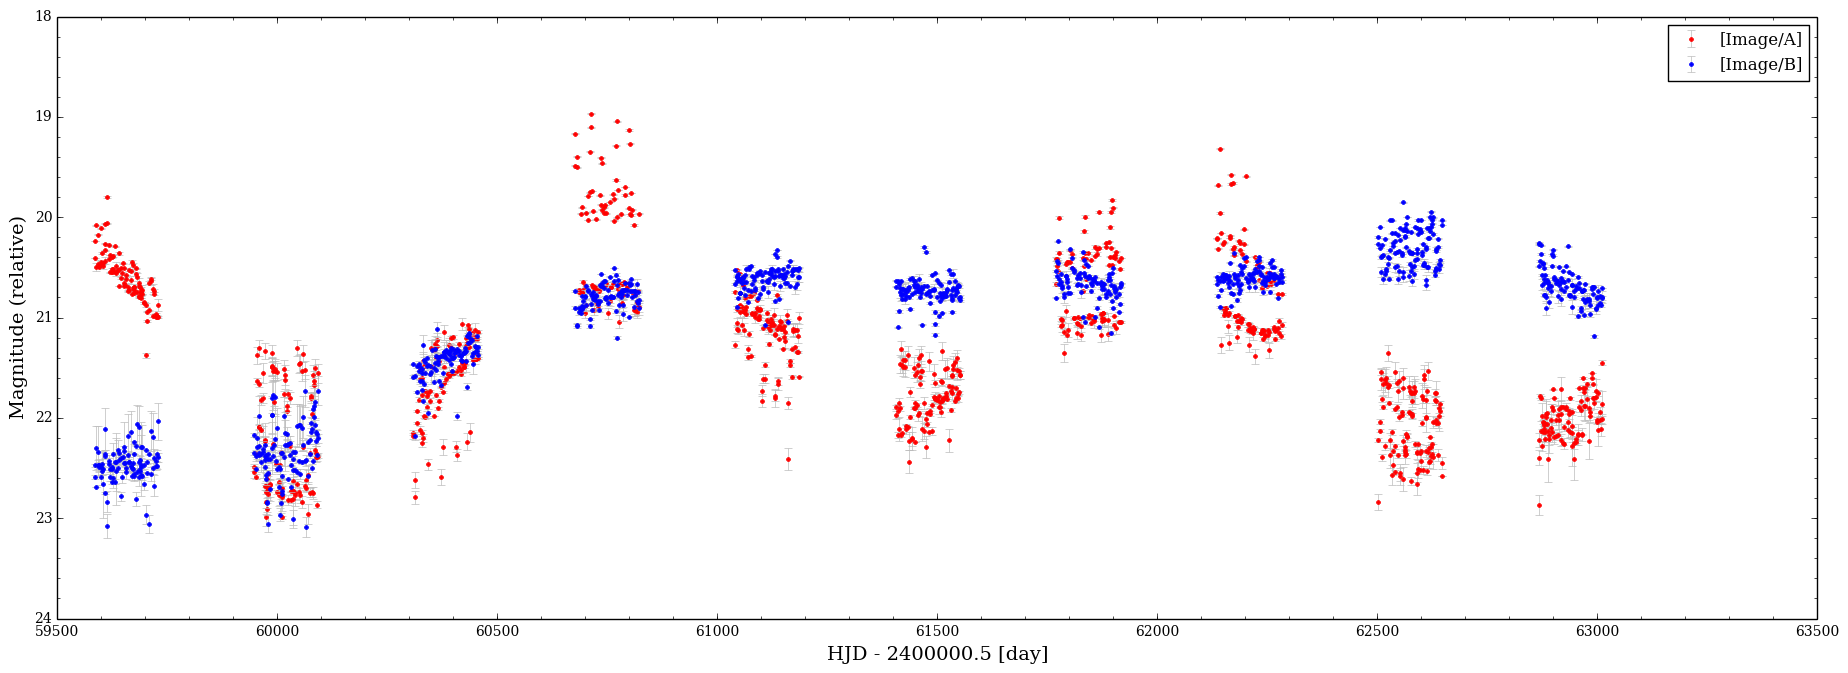

In [3]:
timer = desc.sltimer.SLTimer()
url = "http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-2.txt"
timer.download(url, and_read=True, format='tdc2')
timer.whiten(seasonal=False)
timer.display_light_curves()
name_data="Gateway_2_ml350_all_50_delay_chi2_1000_samples.txt"
SampleUrl="http://stanford.edu/~chto/SLTimer_TDC2_Nolensing_number_of_Knots_test/GateWay2/"

In [4]:
timer.ml_knotstep=350
timer.knotstep=50

In [5]:
import os, urllib
def getFile(knotstep):
    name=name_data.format(knotstep)
    url=SampleUrl+name
    urllib.urlretrieve(url, name)
def plot_file(timer, knotstep, batch_sigma=False, method="plot_log_file"):
    name=name_data.format(knotstep)
    print(name)
    timer.plot_likelihood_from_file(name, outName="", chisquare=True, bins=200,corner_plot=False, add_prior=True, batch_sigma=batch_sigma, method=method)
def batch_analyze(timer, knotstep, batch_sigma=False, download=True, method="plot_log_file"):
    timer.knotstep=knotstep
    timer.ml_knotstep=350
    if download:
        getFile(knotstep)
    plot_file(timer, knotstep, batch_sigma=batch_sigma, method=method)
    print("degree of freedom is : {0}".format(timer.degree_of_freedom()))
def plot_light_curve(timer, delay, knotstep,jdrange=(59500,63100)):
    timer.knotstep=knotstep
    lcs, agn = timer.compute_chisq(delay=[delay], getlcs=True)
    timer.display_light_curves(given_curve=(lcs,agn),jdrange=jdrange)
def combile_sigma_File(fileArray, outName):
    with open(outName, 'w') as outfile:
        for index,fname in enumerate(fileArray):
            with open(fname) as infile:
                for line in infile:
                    if index!=0:
                        if line[0]=='#':
                            continue
                    outfile.write(line)

get likelihood files

In [6]:
name_data_original="Gateway_2_Rescaled_{0}_ml350_all_50_delay_chi2_1000_samples.txt"
for sigma in [0,0.2,0.02,0.002,0.0002]:
    name_data=name_data_original.format(sigma)
    getFile(knotstep=50)

In [7]:
combile_sigma_File(fileArray=["Gateway_2_Rescaled_0_ml350_all_50_delay_chi2_1000_samples.txt",
                              "Gateway_2_Rescaled_0.2_ml350_all_50_delay_chi2_1000_samples.txt",
                              "Gateway_2_Rescaled_0.02_ml350_all_50_delay_chi2_1000_samples.txt",
                              "Gateway_2_Rescaled_0.002_ml350_all_50_delay_chi2_1000_samples.txt",
                              "Gateway_2_Rescaled_0.0002_ml350_all_50_delay_chi2_1000_samples.txt"], 
                   outName='combined.txt')

combined log likelihood

combined.txt


/Users/chto/Projects/lsst/code/SLTimer/python/desc/sltimer/worker.py:152: RuntimeWarning: divide by zero encountered in log
  log_prior[:, 1] = np.log(prior)
/Users/chto/Projects/lsst/code/SLTimer/python/desc/sltimer/worker.py:581: RuntimeWarning: invalid value encountered in divide
  ax.step(bincentres, wd/counts, where='mid', color=color,


Starting ML optimization ...
Done !
Starting ML optimization ...
Done !
knotstep for intrinsic fluctuation is: 50
knotstep for micro lensing is: 350
number of data points is: 2028
degree of freedom is : {'dof': 1772, '# data': 2028}


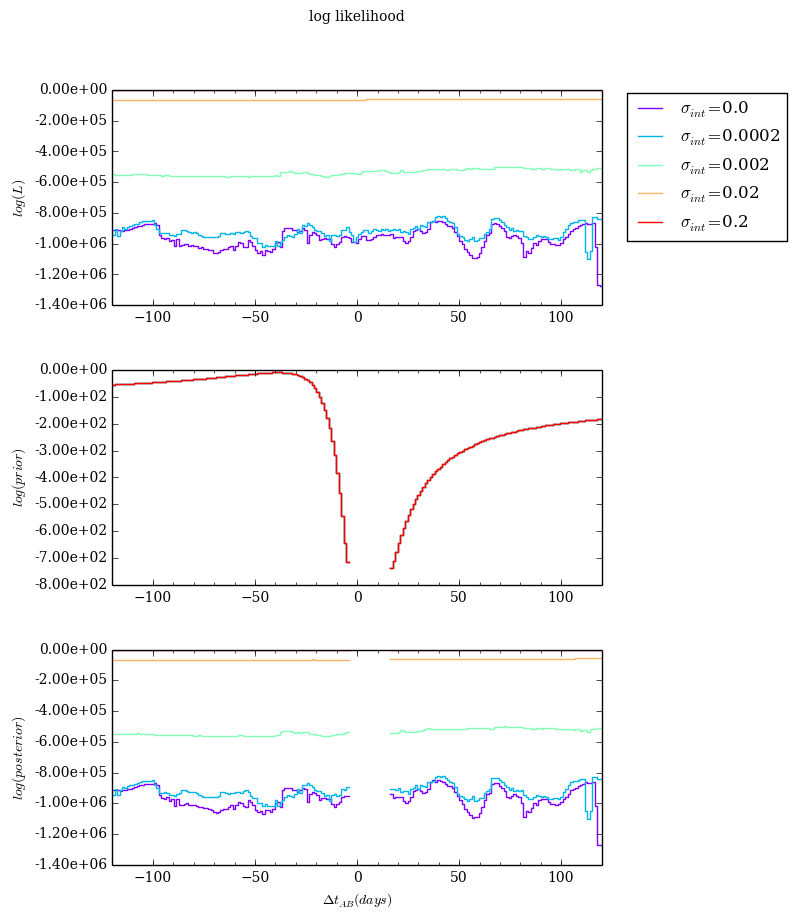

In [8]:
name_data="combined.txt"
batch_analyze(timer, knotstep=50, batch_sigma=True, download=False)

Sigma_init = 0.2 is too large for this figure, so I plot it individually.

Gateway_2_Rescaled_0.2_ml350_all_50_delay_chi2_1000_samples.txt
2.7801125635
30.1735529565
2.30391774217


/Users/chto/Projects/lsst/code/SLTimer/python/desc/sltimer/worker.py:152: RuntimeWarning: divide by zero encountered in log
  log_prior[:, 1] = np.log(prior)


Starting ML optimization ...
Done !
Starting ML optimization ...
Done !
knotstep for intrinsic fluctuation is: 50
knotstep for micro lensing is: 350
number of data points is: 2028
degree of freedom is : {'dof': 1766, '# data': 2028}


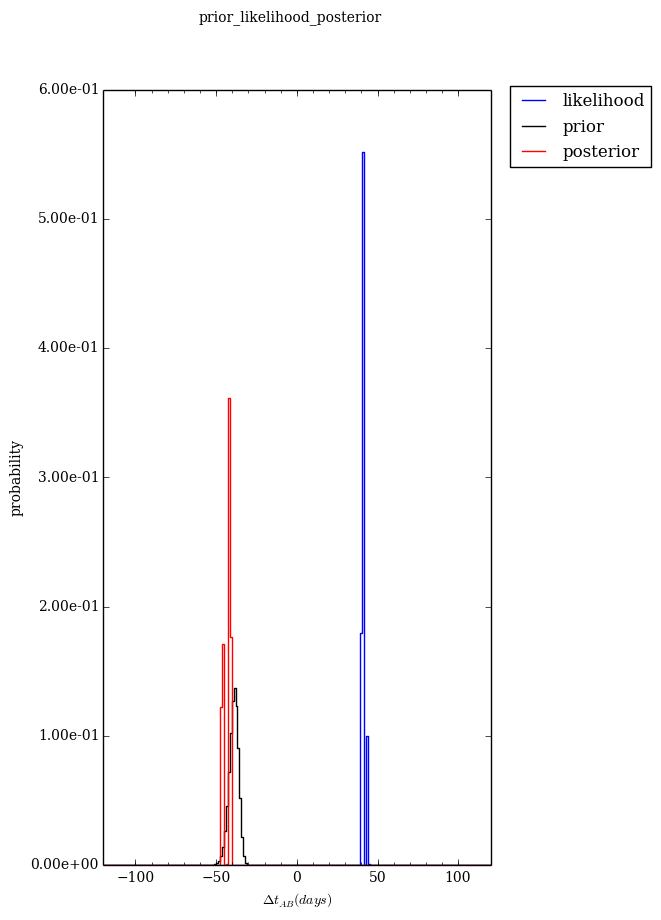

In [18]:
name_data="Gateway_2_Rescaled_0.2_ml350_all_50_delay_chi2_1000_samples.txt"
batch_analyze(timer, knotstep=50, method="plot exp in same graph")

Gateway_2_Rescaled_0.2_ml350_all_50_delay_chi2_1000_samples.txt


/Users/chto/Projects/lsst/code/SLTimer/python/desc/sltimer/worker.py:581: RuntimeWarning: invalid value encountered in divide
  ax.step(bincentres, wd/counts, where='mid', color=color,


Starting ML optimization ...
Done !
Starting ML optimization ...
Done !
knotstep for intrinsic fluctuation is: 50
knotstep for micro lensing is: 350
number of data points is: 2028
degree of freedom is : {'dof': 1766, '# data': 2028}


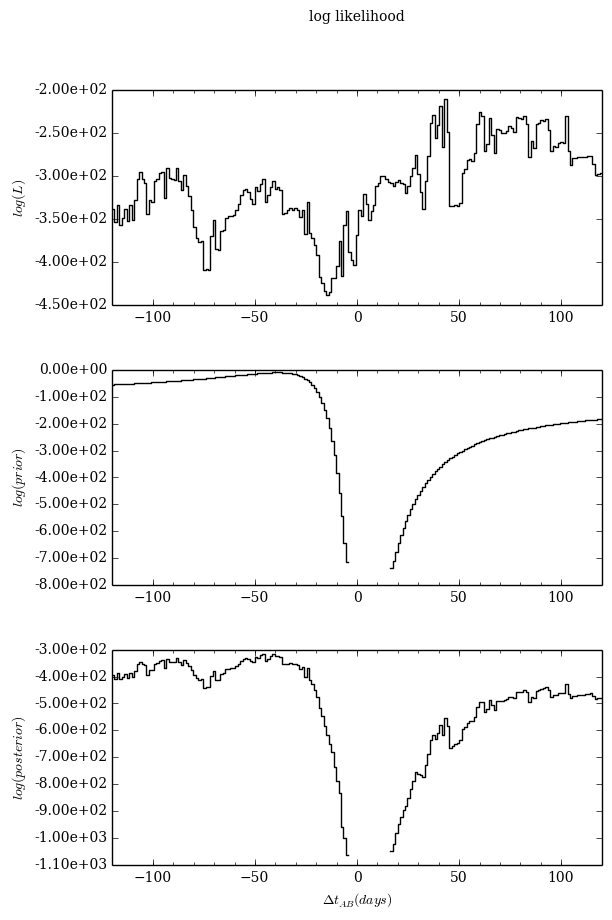

In [17]:
name_data="Gateway_2_Rescaled_0.2_ml350_all_50_delay_chi2_1000_samples.txt"
batch_analyze(timer, knotstep=50)

To compare I plot sigma=0

Gateway_2_Rescaled_0_ml350_all_50_delay_chi2_1000_samples.txt
Starting ML optimization ...
Done !
Starting ML optimization ...
Done !
knotstep for intrinsic fluctuation is: 50
knotstep for micro lensing is: 350
number of data points is: 2028
degree of freedom is : {'dof': 1768, '# data': 2028}


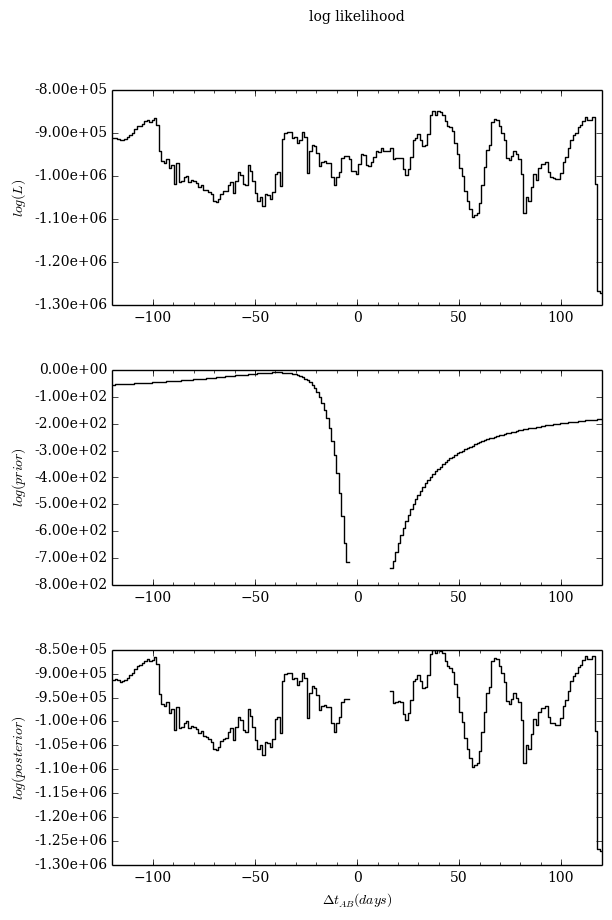

In [12]:
name_data="Gateway_2_Rescaled_0_ml350_all_50_delay_chi2_1000_samples.txt"
batch_analyze(timer, knotstep=50)

Another way to see this is to plot likelihood to sigma diagram given true time delay

In [13]:
def get_loglikelihood(timer, sigma, delay):
    timer.reset_lc()
    timer.sigma_intrinsic = sigma
    timer.rescale_noise()
    chisquare=timer.chisquare_to_loglikelihood(timer.compute_chisq([delay], batch=False, getlcs=False))
    timer.reset_noise() 
    return chisquare

In [20]:
sigma_Array=np.logspace(-2,0,50)
delays=[39.1,0,-39.1]
likelihoodResult={}
for delay in delays:
    likelihood=[]
    for sigma in sigma_Array:
        print(delay)
        likelihood.append(get_loglikelihood(timer, sigma, -39.1))
    likelihoodResult[delay]=likelihood

39.1
add additional noise 0.01
Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/8~|
Working on the spline ML of [Image/B](-39.100,0.608,0)|~3/u/8~|
Done !
Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/8~|
Working on the spline ML of [Image/B](-39.100,0.608,0)|~3/u/8~|
Done !
-6751.93582463
delete additional noise 0.01
39.1
add additional noise 0.0109854114199
Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/8~|
Working on the spline ML of [Image/B](-39.100,0.608,0)|~3/u/8~|
Done !
Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/8~|
Working on the spline ML of [Image/B](-39.100,0.608,0)|~3/u/8~|
Done !
-6726.55664447
delete additional noise 0.0109854114199
39.1
add additional noise 0.0120679264064
Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/8~|
Working on the spline ML of [Image/B](-39.100,0.608,0)|~3/u/8~|
Done !
Starting ML optimization ...
Working on the spline 

0.01


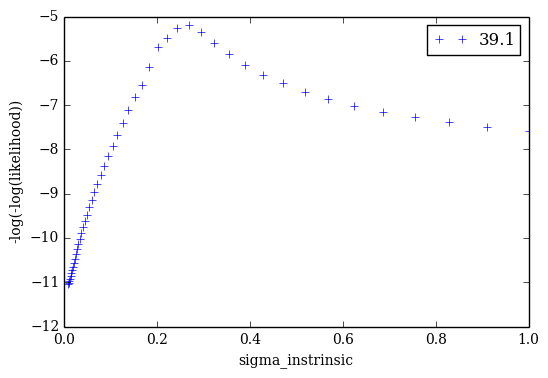

In [23]:
from matplotlib import pyplot as plt
print(min(sigma_Array))
for delay in [39.1]:
    likelihood_delay=np.array(likelihoodResult[delay])
    plt.plot(sigma_Array, -np.log(-likelihood_delay),"+", label=str(delay))
    plt.ylabel("-log(-log(likelihood))")
    plt.xlabel('sigma_instrinsic')
plt.legend()

We see the peak is at 0.2, which is consitant with what we saw.

Conclusion:
1. sigma=0.2 do improve the fitting. 
2. the posterior  of sigma =0.2 recover the true time delay
3. I am still worried about why the likelihood for sigma=0.2 do not recover the true time delay (In fact even get worse compring to sigma=0)